# CTGAN Model Creator
Этот ноутбук автоматически создает CTGAN модели для всех датасетов и методов кодирования

In [ ]:
import pandas as pd
import numpy as np
from ctgan import CTGAN
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from pathlib import Path
import ast
import os
import traceback

## 1. Функции для работы с реестром датасетов

In [ ]:
def load_datasets_registry(registry_path='datasets/datasets_registry.csv'):
    """
    Загружает реестр датасетов и преобразует его в список структур.
    
    Args:
        registry_path: путь к файлу datasets_registry.csv
    
    Returns:
        list: список словарей с информацией о датасетах
    """
    df = pd.read_csv(registry_path, skipinitialspace=True)
    
    datasets_list = []
    for _, row in df.iterrows():
        if pd.isna(row['cat_col']):
            cat_cols_list = []
        else:
            cat_col_str = str(row['cat_col']).replace('\n', '').replace('\r', '').strip()
            try:
                if cat_col_str:
                    cat_cols_list = ast.literal_eval(cat_col_str)
                else:
                    cat_cols_list = []
            except (ValueError, SyntaxError):
                cat_cols_list = []
        
        dataset_info = {
            'dataset_name': row['dataset_name'].strip(),
            'dataset_path': row['dataset_path'].strip(),
            'dataset_csv': row['dataset_csv'].strip(),
            'target': row['target'].strip(),
            'cat_cols': cat_cols_list
        }
        datasets_list.append(dataset_info)
    
    return datasets_list

In [ ]:
def load_encoded_datasets(dataset_info):
    """
    Загружает информацию о закодированных версиях датасета из data.csv.
    
    Args:
        dataset_info: словарь с информацией о датасете
    
    Returns:
        list: список словарей с информацией о закодированных датасетах
    """
    data_csv_path = Path(dataset_info['dataset_csv'])
    
    if not os.path.exists(data_csv_path):
        print(f"  ⚠️ Файл {data_csv_path} не найден")
        return []
    
    df = pd.read_csv(data_csv_path)
    
    encoded_datasets = []
    for _, row in df.iterrows():
        try:
            new_cat_cols = ast.literal_eval(str(row['New_cat_cols']))
        except:
            new_cat_cols = []
        
        encoded_info = {
            'method': row['method'],
            'path': row['path'],
            'New_cat_cols': new_cat_cols,
            'model_path': row.get('model_path', ''),
            'schedul_path': row.get('schedul_path', ''),
            'dataset_name': dataset_info['dataset_name'],
            'dataset_folder': Path(dataset_info['dataset_csv']).parent
        }
        encoded_datasets.append(encoded_info)
    
    return encoded_datasets

## 2. Функция для визуализации лоссов

In [ ]:
def plot_ctgan_losses(loss_df: pd.DataFrame, smooth_window: int = 10, save_path: str = None):
    """
    Красивый график лоссов CTGAN.
    
    Args:
        loss_df: DataFrame из ctgan.loss_values
        smooth_window: окно сглаживания (эпох)
        save_path: если задан, сохранить PNG по этому пути
    """
    if loss_df is None or len(loss_df) == 0:
        print("  ⚠️ График не может быть построен: DataFrame с лоссами пуст.")
        return

    # Пытаемся угадать имена столбцов (гибкий поиск)
    cols_lower = {c.lower(): c for c in loss_df.columns}
    g_col_name = next((c for c in cols_lower if "gen" in c), None)
    d_col_name = next((c for c in cols_lower if "dis" in c), None)

    g_col = cols_lower.get(g_col_name)
    d_col = cols_lower.get(d_col_name)

    # Фоллбэк: берем первые два столбца
    if g_col is None or d_col is None:
        if len(loss_df.columns) < 2:
            print(f"  ⚠️ График не может быть построен: loss_df должен содержать хотя бы 2 столбца (G и D), найдено {len(loss_df.columns)}")
            return
        g_col, d_col = loss_df.columns[:2]

    # Индекс эпох (начнем с 1)
    epochs = np.arange(1, len(loss_df) + 1)

    # Приводим к float на всякий случай
    df = loss_df.copy()
    for c in [g_col, d_col]:
        df[c] = pd.to_numeric(df[c], errors="coerce")

    # Сглаживание
    g_smooth = df[g_col].rolling(smooth_window, min_periods=1).mean()
    d_smooth = df[d_col].rolling(smooth_window, min_periods=1).mean()

    plt.figure(figsize=(10, 6), dpi=120)

    # Тонкие «сырые» линии
    plt.plot(epochs, df[g_col], alpha=0.25, linewidth=1, label=f"{g_col} (raw)")
    plt.plot(epochs, df[d_col], alpha=0.25, linewidth=1, label=f"{d_col} (raw)")

    # Толстые сглаженные
    plt.plot(epochs, g_smooth, linewidth=2.5, label=f"{g_col} (smoothed)")
    plt.plot(epochs, d_smooth, linewidth=2.5, label=f"{d_col} (smoothed)")

    # Аннотации: последние значения и минимумы
    def annotate_series(y, name):
        if y.empty or y.isnull().all(): return
        y_last = float(y.iloc[-1])
        y_min = float(y.min())
        x_min = int(y.idxmin()) + 1
        plt.scatter([len(y)], [y_last], s=30)
        plt.text(len(y), y_last, f"  last: {y_last:.3f}", va="center")
        plt.scatter([x_min], [y_min], s=30)
        plt.text(x_min, y_min, f"  min@{x_min}: {y_min:.3f}", va="center")

    annotate_series(g_smooth, g_col)
    annotate_series(d_smooth, d_col)

    plt.title("CTGAN Training Losses")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.legend(loc="best", frameon=True)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, bbox_inches="tight")
    plt.show()

## 3. Функция для тренировки CTGAN

In [ ]:
def train_ctgan_for_encoded_dataset(encoded_info, epochs=300, verbose=True):
    """
    Тренирует CTGAN модель для закодированного датасета.
    
    Args:
        encoded_info: словарь с информацией о закодированном датасете
        epochs: количество эпох для обучения
        verbose: выводить ли прогресс обучения
    
    Returns:
        tuple: (ctgan_model, loss_df) или (None, None) в случае ошибки
    """
    try:
        data_path = Path(encoded_info['path'])
        print(f"\n{'='*70}")
        print(f"📊 Датасет: {encoded_info['dataset_name']}")
        print(f"🔧 Метод: {encoded_info['method']}")
        print(f"📁 Путь: {data_path}")
        
        if not os.path.exists(data_path):
            print(f"  ⚠️ Файл {data_path} не найден, пропускаем")
            return None, None
        
        df = pd.read_csv(data_path)
        print(f"  ✅ Загружено {len(df)} строк, {len(df.columns)} колонок")
        
        discrete_features = encoded_info['New_cat_cols']
        discrete_features = [col for col in discrete_features if col in df.columns]
        print(f"  🏷️ Дискретных признаков: {len(discrete_features)}")
        
        print(f"  🚀 Начинаем обучение CTGAN ({epochs} эпох)...")
        ctgan = CTGAN(
            epochs=epochs,
            verbose=verbose
        )
        ctgan.fit(df, discrete_features)
        
        loss_df = ctgan.loss_values
        print(f"  ✅ Обучение завершено!")
        
        return ctgan, loss_df
        
    except Exception as e:
        print(f"  ❌ Ошибка при обучении: {e}")
        traceback.print_exc()
        return None, None

In [ ]:
def save_ctgan_results(ctgan, loss_df, encoded_info, data_csv_path):
    """
    Сохраняет модель, график лоссов и обновляет data.csv.
    
    Args:
        ctgan: обученная модель CTGAN
        loss_df: DataFrame с лоссами
        encoded_info: словарь с информацией о закодированном датасете
        data_csv_path: путь к data.csv
    """
    try:
        dataset_folder = encoded_info['dataset_folder']
        dataset_name = encoded_info['dataset_name']
        method = encoded_info['method']

        models_folder = dataset_folder / 'models'
        schedules_folder = dataset_folder / 'training_schedules'
        models_folder.mkdir(exist_ok=True)
        schedules_folder.mkdir(exist_ok=True)

        model_filename = f"ctgan_{dataset_name}_{method}_model.pkl"
        schedule_filename = f"ctgan_{dataset_name}_{method}_losses.png"

        model_path = models_folder / model_filename
        schedule_path = schedules_folder / schedule_filename

        ctgan.save(str(model_path))
        print(f"  💾 Модель сохранена: {model_path}")

        if loss_df is not None and not loss_df.empty:
            plot_ctgan_losses(loss_df, save_path=str(schedule_path))
            print(f"  📈 График сохранен: {schedule_path}")
        else:
            print("  ⚠️ Пропускаем сохранение графика: нет данных о лоссах.")
            schedule_path = None

        df = pd.read_csv(data_csv_path)

        if 'model_path' not in df.columns:
            df['model_path'] = ''
        if 'schedul_path' not in df.columns:
            df['schedul_path'] = ''

        mask = df['method'] == method

        model_rel_path = str(model_path)
        schedule_rel_path = str(schedule_path) if schedule_path else ''

        df.loc[mask, 'model_path'] = model_rel_path
        df.loc[mask, 'schedul_path'] = schedule_rel_path

        df.to_csv(data_csv_path, index=False)
        print(f"  📝 Обновлен {data_csv_path}")

    except Exception as e:
        print(f"  ❌ Ошибка при сохранении: {e}")
        traceback.print_exc()

## 4. Главная функция для обработки всех датасетов

In [ ]:
def process_all_datasets(epochs=300, verbose=True):
    """
    Обрабатывает все датасеты из реестра.
    
    Args:
        epochs: количество эпох для обучения каждой модели
        verbose: выводить ли прогресс обучения
    """
    print("="*70)
    print("🚀 CTGAN Model Creator")
    print("="*70)
    
    datasets = load_datasets_registry()
    print(f"\n📋 Загружено датасетов: {len(datasets)}")
    
    total_models = 0
    successful_models = 0
    
    for dataset_info in datasets:
        print(f"\n{'='*70}")
        print(f"📦 Обработка датасета: {dataset_info['dataset_name']}")
        print(f"{'='*70}")
        
        encoded_datasets = load_encoded_datasets(dataset_info)
        print(f"  📊 Найдено закодированных версий: {len(encoded_datasets)}")
        
        if len(encoded_datasets) == 0:
            print(f"  ⚠️ Пропускаем датасет (нет закодированных версий)")
            continue
        
        for encoded_info in encoded_datasets:
            total_models += 1
            
            ctgan, loss_df = train_ctgan_for_encoded_dataset(
                encoded_info, 
                epochs=epochs, 
                verbose=verbose
            )
            
            if ctgan is not None:
                data_csv_path = Path(dataset_info['dataset_csv'])
                save_ctgan_results(ctgan, loss_df, encoded_info, data_csv_path)
                successful_models += 1
    
    print(f"\n{'='*70}")
    print(f"✅ ЗАВЕРШЕНО!")
    print(f"{'='*70}")
    print(f"  Всего моделей для обучения: {total_models}")
    print(f"  Успешно обучено: {successful_models}")
    print(f"  Ошибок: {total_models - successful_models}")
    print(f"{'='*70}")

## 5. Запуск обработки

In [ ]:
datasets = load_datasets_registry()
print(f"Загружено датасетов: {len(datasets)}")
print("\nСписок датасетов:")
for ds in datasets:
    print(f"  - {ds['dataset_name']}")

Загружено датасетов: 11

Список датасетов:
  - adult
  - bank_marketing
  - california_housing
  - chess_kr_k
  - connect_4
  - default_credit
  - letter_recognition
  - magic_gamma
  - nursery
  - online_shoppers
  - phishing_websites


In [ ]:
if len(datasets) > 0:
    encoded = load_encoded_datasets(datasets[0])
    print(f"\nЗакодированные версии для '{datasets[0]['dataset_name']}':")
    for enc in encoded:
        print(f"  - {enc['method']}: {enc['path']}")
        print(f"    Дискретных колонок: {len(enc['New_cat_cols'])}")


Закодированные версии для 'adult':
  - one_hot_encoding: datasets/adult/adult_ohe.csv
    Дискретных колонок: 113
  - label_encoding: datasets/adult/adult_label.csv
    Дискретных колонок: 10
  - frequency_encoding: datasets/adult/adult_frequency.csv
    Дискретных колонок: 10
  - original: datasets/adult/adult_original.csv
    Дискретных колонок: 0


In [ ]:
# ЗАПУСК: Обработка всех датасетов
# Параметры:
# - epochs: количество эпох обучения (по умолчанию 300)
# - verbose: выводить прогресс (True/False)

process_all_datasets(epochs=3, verbose=True)

🚀 CTGAN Model Creator

📋 Загружено датасетов: 11

📦 Обработка датасета: adult
  📊 Найдено закодированных версий: 4

📊 Датасет: adult
🔧 Метод: one_hot_encoding
📁 Путь: datasets/adult/adult_ohe.csv
  ✅ Загружено 10000 строк, 119 колонок
  🏷️ Дискретных признаков: 113
  🚀 Начинаем обучение CTGAN (3 эпох)...


Traceback (most recent call last):
Traceback (most recent call last):
  File "<frozen runpy>", line 189, in _run_module_as_main
  File "<frozen runpy>", line 112, in _get_module_details
  File "/Users/hatiko/Documents/GitHub/NIR/.venv/lib/python3.13/site-packages/joblib/__init__.py", line 114, in <module>
    from ._cloudpickle_wrapper import wrap_non_picklable_objects
  File "/Users/hatiko/Documents/GitHub/NIR/.venv/lib/python3.13/site-packages/joblib/_cloudpickle_wrapper.py", line 14, in <module>
    from .externals.loky import wrap_non_picklable_objects
  File "/Users/hatiko/Documents/GitHub/NIR/.venv/lib/python3.13/site-packages/joblib/externals/loky/__init__.py", line 20, in <module>
    from .backend.reduction import set_loky_pickler
  File "<frozen runpy>", line 189, in _run_module_as_main
  File "<frozen runpy>", line 112, in _get_module_details
  File "/Users/hatiko/Documents/GitHub/NIR/.venv/lib/python3.13/site-packages/joblib/__init__.py", line 115, in <module>
    from ._pa

KeyboardInterrupt: 

## 6. Дополнительные утилиты

In [ ]:
def train_single_dataset(dataset_name, method, epochs=300):
    """
    Обучает модель для конкретного датасета и метода кодирования.
    
    Args:
        dataset_name: имя датасета (например, 'adult')
        method: метод кодирования (например, 'one_hot_encoding')
        epochs: количество эпох
    """
    datasets = load_datasets_registry()
    
    dataset_info = next((ds for ds in datasets if ds['dataset_name'] == dataset_name), None)
    
    if dataset_info is None:
        print(f"❌ Датасет '{dataset_name}' не найден")
        return
    
    encoded_datasets = load_encoded_datasets(dataset_info)
    
    encoded_info = next((enc for enc in encoded_datasets if enc['method'] == method), None)
    
    if encoded_info is None:
        print(f"❌ Метод '{method}' не найден для датасета '{dataset_name}'")
        print(f"Доступные методы: {[enc['method'] for enc in encoded_datasets]}")
        return
    
    ctgan, loss_df = train_ctgan_for_encoded_dataset(encoded_info, epochs=epochs, verbose=True)
    
    if ctgan is not None:
        data_csv_path = Path(dataset_info['dataset_csv'])
        save_ctgan_results(ctgan, loss_df, encoded_info, data_csv_path)
        print(f"\n✅ Модель успешно обучена и сохранена!")
    else:
        print(f"\n❌ Ошибка при обучении модели")


📊 Датасет: adult
🔧 Метод: one_hot_encoding
📁 Путь: datasets/adult/adult_ohe.csv
  ✅ Загружено 10000 строк, 119 колонок
  🏷️ Дискретных признаков: 113
  🚀 Начинаем обучение CTGAN (300 эпох)...


Gen. (-11.22) | Discrim. (0.48): 100%|██████████| 300/300 [23:05<00:00,  4.62s/it]  


  ✅ Обучение завершено!
  💾 Модель сохранена: datasets/adult/models/ctgan_adult_one_hot_encoding_model.pkl


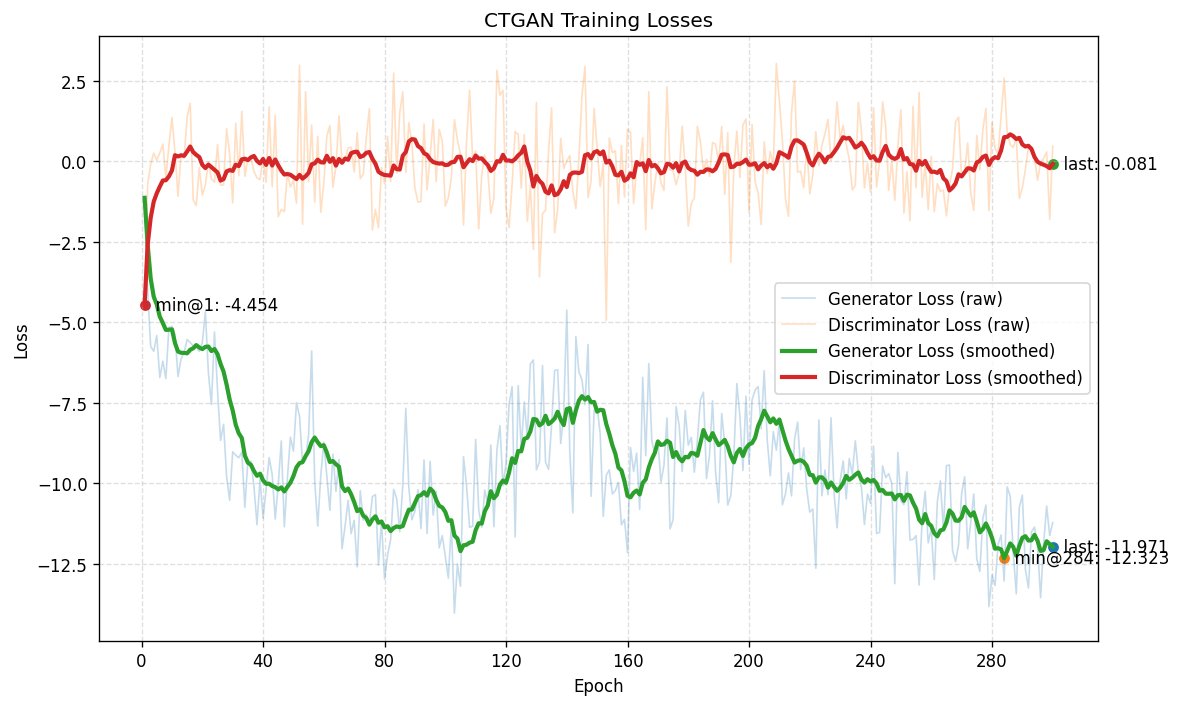

  📈 График сохранен: datasets/adult/training_schedules/ctgan_adult_one_hot_encoding_losses.png
  📝 Обновлен datasets/adult/data.csv

✅ Модель успешно обучена и сохранена!


In [ ]:
#Пример использования: обучить одну модель
train_single_dataset('adult', 'one_hot_encoding', epochs=300)

## 7. Просмотр результатов

In [ ]:
def show_results_summary():
    """
    Выводит сводку по всем обученным моделям.
    """
    datasets = load_datasets_registry()
    
    print("="*100)
    print("📊 СВОДКА ПО ОБУЧЕННЫМ МОДЕЛЯМ")
    print("="*100)
    
    for dataset_info in datasets:
        data_csv_path = Path(dataset_info['dataset_csv'])
        
        if not os.path.exists(data_csv_path):
            continue
        
        # При чтении CSV сразу заменяем возможные NaN на пустые строки
        df = pd.read_csv(data_csv_path).fillna('')

        print(f"\n📦 {dataset_info['dataset_name'].upper()}")
        print("-"*100)

        for _, row in df.iterrows():
            method = row['method']
            # Теперь эти значения гарантированно будут строками
            model_path = row.get('model_path', '')
            schedule_path = row.get('schedul_path', '')

            model_exists = "✅" if model_path and os.path.exists(Path(model_path)) else "❌"
            schedule_exists = "✅" if schedule_path and os.path.exists(Path(schedule_path)) else "❌"

            print(f"  {method:20s} | Модель: {model_exists} | График: {schedule_exists}")
            if model_path:
                print(f"    └─ Модель: {model_path}")
            if schedule_path:
                print(f"    └─ График: {schedule_path}")


In [ ]:
# Показать сводку по всем моделям
show_results_summary()

📊 СВОДКА ПО ОБУЧЕННЫМ МОДЕЛЯМ

📦 ADULT
----------------------------------------------------------------------------------------------------
  one_hot_encoding     | Модель: ✅ | График: ✅
    └─ Модель: datasets/adult/models/ctgan_adult_one_hot_encoding_model.pkl
    └─ График: datasets/adult/training_schedules/ctgan_adult_one_hot_encoding_losses.png
  label_encoding       | Модель: ✅ | График: ✅
    └─ Модель: datasets/adult/models/ctgan_adult_label_encoding_model.pkl
    └─ График: datasets/adult/training_schedules/ctgan_adult_label_encoding_losses.png
  frequency_encoding   | Модель: ✅ | График: ✅
    └─ Модель: datasets/adult/models/ctgan_adult_frequency_encoding_model.pkl
    └─ График: datasets/adult/training_schedules/ctgan_adult_frequency_encoding_losses.png
  original             | Модель: ❌ | График: ❌

📦 BANK_MARKETING
----------------------------------------------------------------------------------------------------
  one_hot_encoding     | Модель: ✅ | График: ✅
    └─ Моде